In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS
from tqdm.auto import tqdm
import seaborn as sns
from scipy.signal import find_peaks, savgol_filter
from pathlib import Path
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
from db_models import ORM, Experiment, Strike, Block
from analysis.pose_utils import plot_regression, colorline
from analysis.strikes.strikes import Loader

In [2]:
orm = ORM()
BAD_ANIMALS = ['PV03', 'PV26', 'PV72', 'PV87', 'PV90', 'PV101', 'PV119', 'PV144']

In [3]:
with orm.session() as s:
    res = s.query(Strike, Block, Experiment).join(Block, Block.id == Strike.block_id).join(Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.arena.in_(['reptilearn4', 'msi-regev']),
        Experiment.animal_id.not_in(BAD_ANIMALS),
        Experiment.animal_id.startswith('PV'),
        Experiment.start_time > '2023-04-18'
    ).all()

In [4]:
df = []
for strk, blk, exp in res:
    miss_distance = np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2)
    df.append({'strike_id': strk.id, 'time': strk.time, 'animal_id': exp.animal_id, 'miss_distance': miss_distance, 'pred_distance': strk.prediction_distance,
              'movement_type': blk.movement_type, 'calc_speed': strk.calc_speed, 'proj_strike': strk.projected_strike_coords, 'bug_size': strk.bug_size, 
               'proj_bug_x': strk.projected_leap_coords and strk.projected_leap_coords[0], 'is_hit': strk.is_hit, 'trial_id': strk.trial_id})

df = pd.DataFrame(df)
df['day'] = df.time.dt.floor('d').copy()
df['trial_id'] = df.trial_id.astype('Int32')
df['proj_strike_x'] = df.proj_strike.map(lambda x: x[0] if x and len(x)==2 else None)
df['proj_strike_y'] = df.proj_strike.map(lambda x: x[1] if x and len(x)==2 else None)
df['movement_type'] = df.movement_type.replace({'low_horizontal': 'random_low_horizontal'})
df.drop(columns=['proj_strike'], inplace=True)

for animal_id in df.animal_id.unique():
    af_ = df.query(f'animal_id=="{animal_id}"').sort_values(by='strike_id')
    first_day = af_.day.sort_values().iloc[0]
    df.loc[af_.index, 'day_num'] = (af_.day - first_day).dt.days
df.sort_values(by='time')

,strike_id,time,animal_id,miss_distance,pred_distance,movement_type,calc_speed,bug_size,proj_bug_x,is_hit,trial_id,day,proj_strike_x,proj_strike_y,day_num
349,596,2023-04-18 12:56:27.388,PV85,36.345564,NaN,random_low_horizontal,NaN,150,NaN,True,5968,2023-04-18,NaN,NaN,0.0
350,597,2023-04-18 12:56:55.194,PV85,48.166378,NaN,random_low_horizontal,NaN,155,NaN,True,5969,2023-04-18,NaN,NaN,0.0
378,626,2023-04-18 13:15:37.509,PV85,73.061618,0.534496,random_low_horizontal,4.168878,148,-44.0,True,5972,2023-04-18,-73.0,-3.0,0.0
379,627,2023-04-18 13:17:05.502,PV85,54.037024,0.186961,random_low_horizontal,4.116550,155,-40.0,True,5938,2023-04-18,-50.0,-2.0,0.0
393,643,2023-04-19 09:02:04.452,PV85,76.941536,0.836116,random_low_horizontal,6.265574,141,-120.0,True,6092,2023-04-19,-76.0,12.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,5136,2023-06-26 14:32:14.492,PV97,6.708204,NaN,random_low_horizontal,4.180184,100,-76.0,True,15879,2023-06-26,-6.0,3.0,1.0
3114,5130,2023-06-26 15:31:22.943,PV97,50.358713,NaN,random_low_horizontal,4.107947,100,NaN,True,15886,2023-06-26,NaN,NaN,1.0
3115,5131,2023-06-26 16:31:23.026,PV97,44.777226,2.460524,random_low_horizontal,6.132450,100,-174.0,True,15887,2023-06-26,-41.0,-18.0,1.0
3116,5132,2023-06-26 17:31:23.791,PV97,112.751940,NaN,random_low_horizontal,8.370941,100,-160.0,False,15892,2023-06-26,-112.0,-13.0,1.0


In [170]:
COLORS = list(TABLEAU_COLORS.values()) + list(CSS4_COLORS.values())
COLORS = {aid: COLORS[i] for i, aid in enumerate(df.animal_id.unique())}
COLORS

{'PV42': '#1f77b4', 'PV85': '#ff7f0e', 'PV91': '#2ca02c', 'PV80': '#d62728'}

## Prediction Distance vs. Time in random_low_horizontal

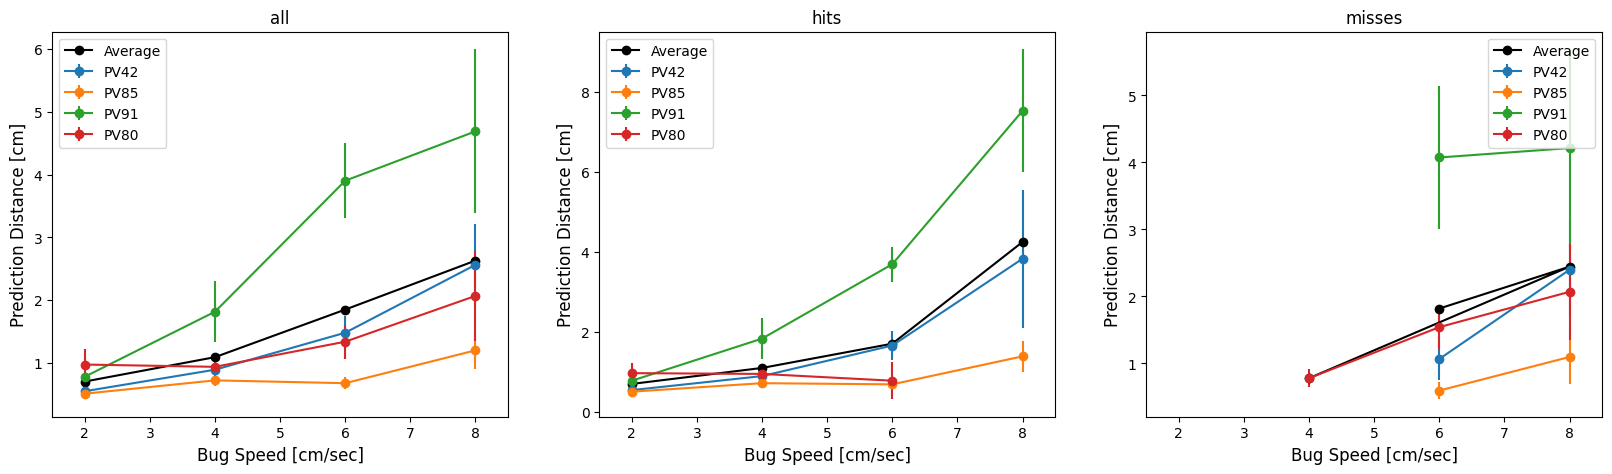

In [173]:
def plot_pred_distance(ax, movement_type, speeds=(2,4,6,8), xlabel_size=12, ylabel_size=12, hit_type='all'):
    assert hit_type in ['all', 'misses', 'hits']
    hit_type_query = ' and is_hit' if hit_type == 'hits' else ' and not is_hit' if hit_type == 'misses' else ''
    avg = []
    for animal_id in df.animal_id.unique():
        af_ = df.query(f'animal_id=="{animal_id}" and movement_type=="{movement_type}"{hit_type_query}')[['calc_speed', 'pred_distance']].copy()
        if af_.empty:
            continue
        af_['round_speed'] = af_.calc_speed.round()
        af_ = af_.query(f'round_speed in {speeds}').copy()
        g_ = af_.groupby('round_speed').pred_distance.agg(['mean', 'sem'])
        g_.dropna(inplace=True)
        avg.append(g_['mean'].to_dict())
        ax.errorbar(g_.index, g_['mean'], yerr=g_['sem'], color=COLORS[animal_id], label=animal_id, fmt='-o')
    
    avg = pd.DataFrame(avg).mean()
    ax.plot(avg.index, avg.values, '-o', label='Average', color='k')
    ax.set_xlabel('Bug Speed [cm/sec]', fontsize=xlabel_size)
    ax.set_ylabel('Prediction Distance [cm]', fontsize=ylabel_size)
    ax.set_xlim([1.5, 8.5])
    ax.legend()


fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, hit_type_ in enumerate(['all', 'hits', 'misses']):
    plot_pred_distance(axes[i], 'random_low_horizontal', hit_type=hit_type_)
    axes[i].set_title(hit_type_)

## Engagement

In [125]:
eng = []
with orm.session() as s:
    exps = s.query(Experiment).filter(
        Experiment.arena.in_(['reptilearn4', 'msi-regev']),
        Experiment.animal_id.not_in(BAD_ANIMALS),
        Experiment.start_time > '2023-04-18').all()
    for exp in tqdm(exps):
        for blk in exp.blocks:
            # if blk.movement_type != 'random_low_horizontal':
            #     continue
            for tr in blk.trials:
                trial_dict = {'trial_id': tr.id, 'animal_id': exp.animal_id, 'time': tr.start_time, 'is_strike': len(tr.strikes) > 0, 'block_id': blk.id, 'bug_speed': blk.bug_speed}
                trial_dict['avg_miss'] = np.nanmean([np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2) for strk in tr.strikes])
                eng.append(trial_dict)

eng = pd.DataFrame(eng)
eng['day'] = eng.time.dt.floor('d').copy()
for animal_id in eng.animal_id.unique():
    af_ = eng.query(f'animal_id=="{animal_id}"')
    first_day = af_.day.sort_values().iloc[0]
    eng.loc[af_.index, 'day_num'] = (af_.day - first_day).dt.days
eng

  0%|          | 0/591 [00:00<?, ?it/s]

/tmp/ipykernel_28069/764168480.py:13: RuntimeWarning: Mean of empty slice
  trial_dict['avg_miss'] = np.nanmean([np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2) for strk in tr.strikes])


,trial_id,animal_id,time,is_strike,block_id,bug_speed,avg_miss,day,day_num
0,5937,PV85,2023-04-18 13:16:40.451,False,990,4,NaN,2023-04-18,0.0
1,5938,PV85,2023-04-18 13:17:02.864,True,990,4,54.037024,2023-04-18,0.0
2,5939,PV85,2023-04-18 13:17:23.697,False,990,4,NaN,2023-04-18,0.0
3,5940,PV85,2023-04-18 13:17:46.045,False,990,4,NaN,2023-04-18,0.0
4,5941,PV85,2023-04-18 13:18:08.387,False,990,4,NaN,2023-04-18,0.0
...,...,...,...,...,...,...,...,...,...
4620,14080,PV91,2023-06-10 17:30:46.284,False,1860,5,NaN,2023-06-10,28.0
4621,14081,PV91,2023-06-10 17:31:55.290,False,1860,5,NaN,2023-06-10,28.0
4622,14082,PV91,2023-06-10 17:31:09.378,False,1860,5,NaN,2023-06-10,28.0
4623,14083,PV91,2023-06-10 17:31:32.357,False,1860,5,NaN,2023-06-10,28.0


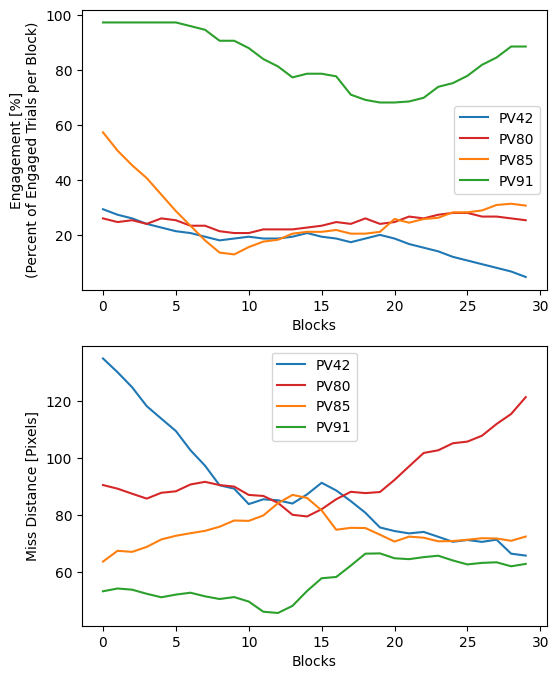

In [136]:
fig, axes = plt.subplots(2, 1, figsize=(6, 8))

g = eng.groupby(['animal_id', 'block_id']).is_strike.agg(['sum', 'count']).reset_index()
g['engagement'] = (g['sum'] / g['count']) * 100
for animal_id in g.animal_id.unique():
    g_ = g.query(f'animal_id=="{animal_id}"').reset_index()
    g_ = g_.iloc[:30]
    g_['engagement'] = savgol_filter(g_.engagement, window_length=15, polyorder=0, mode='nearest')
    axes[0].plot(g_.index, g_['engagement'], label=animal_id, color=COLORS[animal_id])
axes[0].legend()
axes[0].set_xlabel('Blocks')
axes[0].set_ylabel('Engagement [%]\n(Percent of Engaged Trials per Block)')

g = eng.query('is_strike').groupby(['animal_id', 'block_id']).agg({'avg_miss': np.nanmean}).reset_index()
for animal_id in g.animal_id.unique():
    g_ = g.query(f'animal_id=="{animal_id}"').reset_index()
    g_ = g_.iloc[:30]
    g_['avg_miss'] = savgol_filter(g_.avg_miss, window_length=19, polyorder=0, mode='nearest')
    axes[1].plot(g_.index, g_['avg_miss'], label=animal_id, color=COLORS[animal_id])
axes[1].legend()
axes[1].set_xlabel('Blocks')
axes[1].set_ylabel('Miss Distance [Pixels]')
plt.show()

## Miss Distance

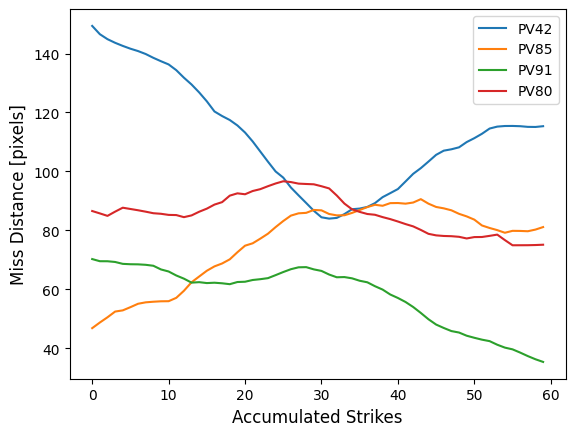

In [121]:
def plot_learning_curve(ax, movement_type, xlabel_size=12, ylabel_size=12, min_strikes=100):
    for animal_id in df.animal_id.unique():
        af_ = df.query(f'animal_id=="{animal_id}" and movement_type=="{movement_type}"').sort_values(by='strike_id').reset_index().copy()
        if af_.empty or (min_strikes and len(af_) < min_strikes):
            continue
        af_ = af_.iloc[:60]
        miss_distance = savgol_filter(af_.miss_distance, window_length=51, polyorder=0, mode='nearest')
        ax.plot(af_.index.tolist(), miss_distance, color=COLORS[animal_id], label=animal_id)
        # if af_.day_num.min() > 0:
        #     af_['day_num'] = af_.day_num - af_.day_num.min() 
        # g_ = af_.groupby('strike_num').miss_distance.agg(['mean', 'sem'])
        # g_['sem'].fillna(0, inplace=True)
        # ax.errorbar(g_.index, g_['mean'], yerr=g_['sem'], color=COLORS[animal_id], label=animal_id, fmt='-o')
        # plot_regression(ax, af_.round_speed.values, af_.pred_distance.values)

    ax.set_xlabel('Accumulated Strikes', fontsize=xlabel_size)
    ax.set_ylabel('Miss Distance [pixels]', fontsize=ylabel_size)
    ax.legend()
    
plot_learning_curve(plt.subplot(), 'random_low_horizontal', min_strikes=70)

## Projected Strikes

In [117]:
max_proj_x, max_proj_y = 300, 300

def plot_projected(ax, af):
    # af = af.query(f'-{max_proj_x} <= proj_bug_x <= {max_proj_x}')
    ax.add_patch(plt.Circle((0, 0), af.bug_size.mean(), color='lemonchiffon', alpha=0.5))
    
    cm = plt.cm.get_cmap('RdYlBu')
    cax = ax.inset_axes([0, 0, 0.5, 0.05])
    sc = ax.scatter(af.proj_strike_x, af.proj_strike_y, c=af.proj_bug_x, cmap=cm)
    cbar = plt.colorbar(sc, ax=ax, cax=cax, orientation="horizontal")
    cbar.set_ticks([])
    ax.set_xlim([-max_proj_x, max_proj_x])
    ax.set_ylim([-max_proj_y, max_proj_y])

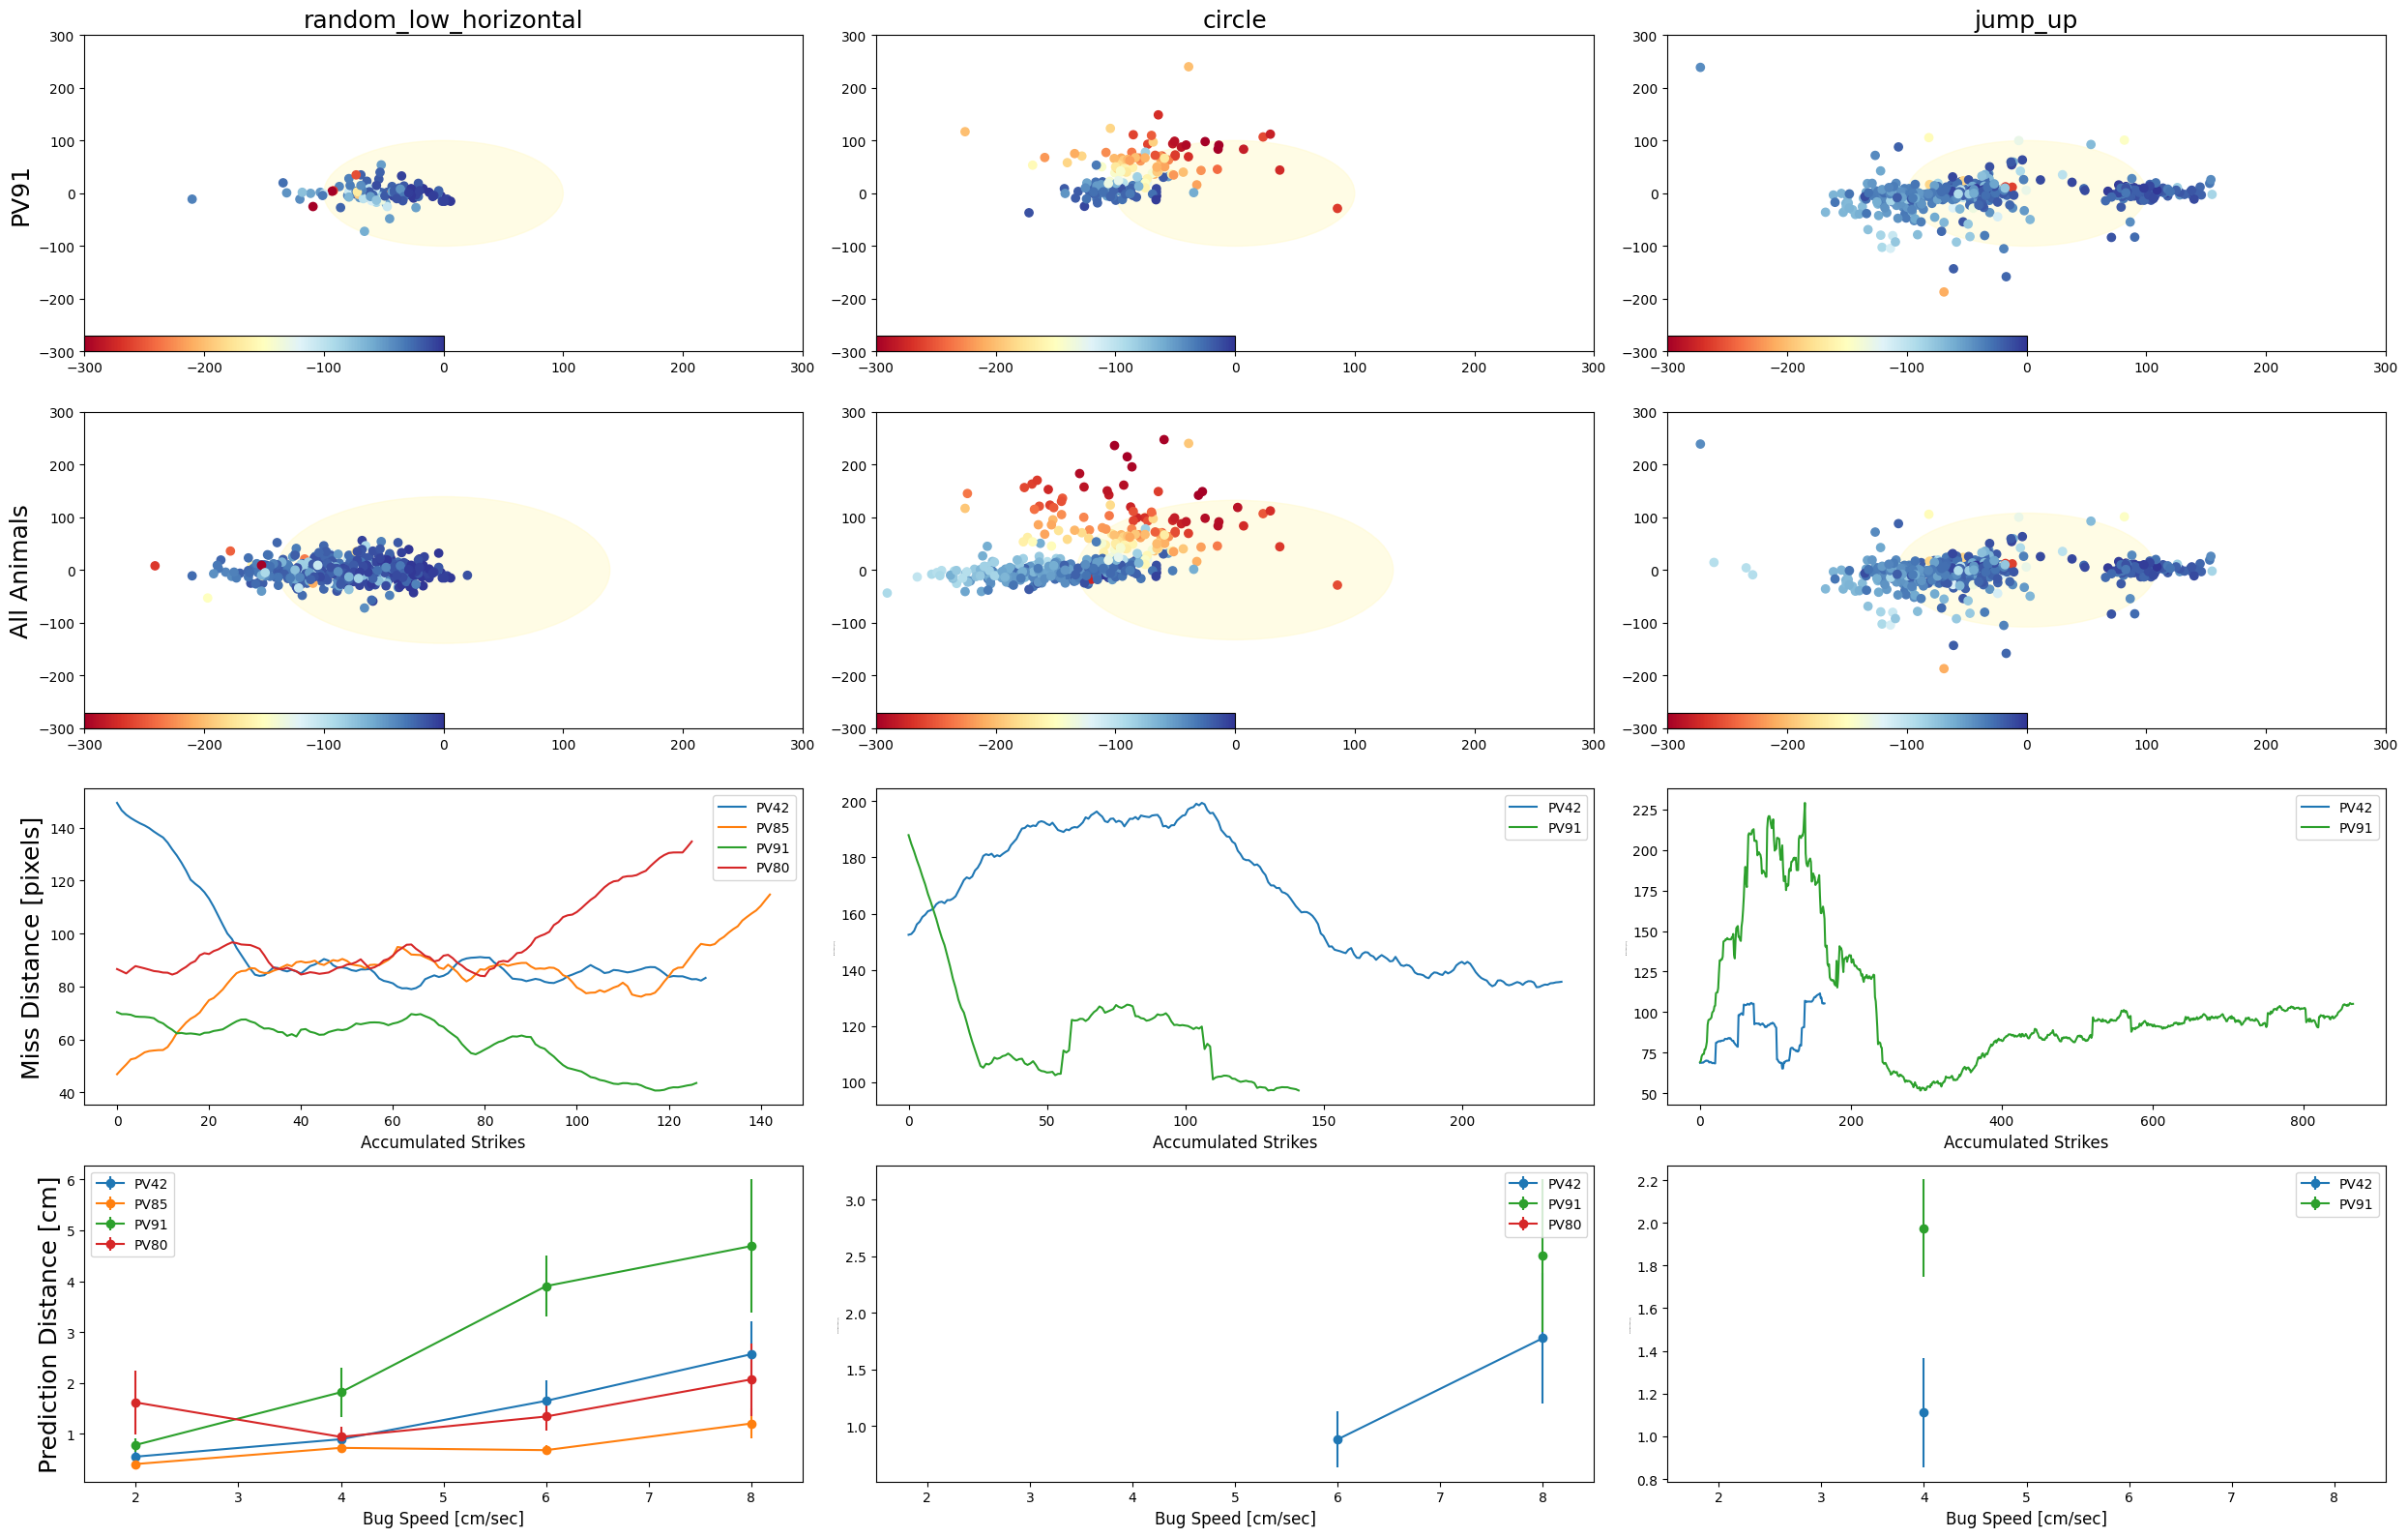

In [118]:
rows = 4
fig, axes = plt.subplots(rows, 3, figsize=(25, 4*rows))

single_animal = 'PV91'
for i, movement_type in enumerate(['random_low_horizontal', 'circle', 'jump_up']):
    # projected single animal
    af_ = df.query(f'animal_id=="{single_animal}" and movement_type=="{movement_type}"')
    plot_projected(axes[0, i], af_)
    axes[0, i].set_title(movement_type, fontsize=18)
    if i == 0:
        axes[0, i].set_ylabel(single_animal, fontsize=18)
    # projected all animals
    af_ = df.query(f'movement_type=="{movement_type}"')
    plot_projected(axes[1, i], af_)
    if i == 0:
        axes[1, i].set_ylabel('All Animals', fontsize=18)
    # learning curves
    plot_learning_curve(axes[2, i], movement_type, ylabel_size=18 if i==0 else 0)
    plot_pred_distance(axes[3, i], movement_type, speeds=(2,4,6,8) if movement_type != 'jump_up' else (4,), ylabel_size=18 if i==0 else 0)
    
fig.tight_layout()

## Jump Up

In [115]:
def get_time_from_prev_jump(strike_id):
    """return time in seconds from the closest jump before strike"""
    dt = np.nan
    try:
        ld = Loader(strike_id, 'front', is_load_pose=False, orm=orm)
        traj = ld.traj_df.copy()
        jump_idx = np.where(traj.y.diff().abs() > 40)[0]

        if len(jump_idx) > 0:
            jump_idx_ = jump_idx[jump_idx < ld.bug_traj_strike_id]
            if len(jump_idx_):
                closest_jump_before = jump_idx_[-1]
                dt = (ld.traj_df.time[ld.bug_traj_strike_id] - ld.traj_df.time[closest_jump_before]).total_seconds()
    except Exception as exc:
        print(f'Strike-{strike_id}: {exc}')
    return dt

Strike-3730: traj_df is empty
Strike-3731: traj_df is empty
Strike-3762: traj_df is empty
Strike-3777: traj_df is empty
Strike-3778: traj_df is empty
Strike-3802: traj_df is empty
Strike-3803: traj_df is empty
Strike-3804: traj_df is empty
Strike-3805: traj_df is empty
Strike-3806: traj_df is empty
Strike-3807: traj_df is empty
Strike-3817: traj_df is empty
Strike-3822: traj_df is empty
Strike-3983: traj_df is empty
Strike-3984: traj_df is empty
Strike-3985: traj_df is empty
Strike-3986: traj_df is empty
Strike-3987: traj_df is empty
Strike-4003: traj_df is empty


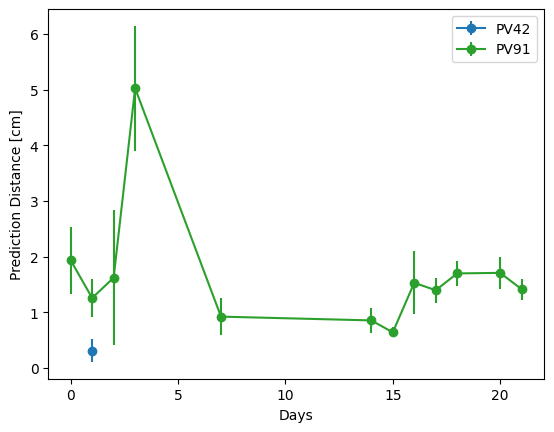

In [116]:
ax = plt.subplot()
for animal_id in df.animal_id.unique():
    if animal_id in ['PV80', 'PV85']:
        continue
    af_ = df.query(f'animal_id=="{animal_id}" and movement_type=="jump_up"').copy()
    af_['time_from_jump'] = af_.strike_id.map(get_time_from_prev_jump)
    
    af_ = af_.query('0.005 <= time_from_jump <= 0.3')
    # af_.dropna(subset=['pred_distance'], inplace=True)
    # af_ = af_.sort_values(by='strike_id').reset_index()
    if af_.empty:
        continue
    # y = savgol_filter(af_.pred_distance, window_length=41, polyorder=0, mode='nearest')
    # ax.plot(af_.index, y, label=animal_id)
    
    if af_.day_num.min() > 0:
        af_['day_num'] = af_.day_num - af_.day_num.min()
    af_.dropna(subset=['pred_distance'], inplace=True)
    g_ = af_.groupby('day_num').pred_distance.agg(['mean', 'sem'])
    g_.dropna(inplace=True)
    ax.errorbar(g_.index, g_['mean'], yerr=g_['sem'], label=animal_id, fmt='-o', color=COLORS[animal_id])
    # plot_regression(ax, af_.round_speed.values, af_.pred_distance.values)

ax.set_xlabel('Days')
ax.set_ylabel('Prediction Distance [cm]')
ax.legend()

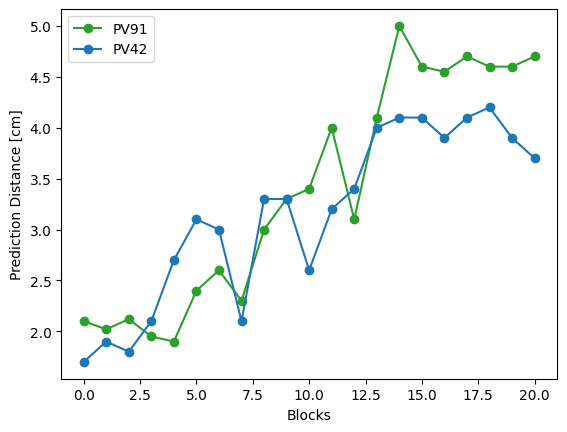

In [165]:
jumps = {
    'PV91': [2.1, 2.02, 2.12, 1.95, 1.9, 2.4, 2.6, 2.3, 3, 3.3, 3.4, 4, 3.1, 4.1, 5, 4.6, 4.55, 4.7, 4.6, 4.6, 4.7],
    'PV42': [1.7, 1.9, 1.8, 2.1, 2.7, 3.1, 3, 2.1, 3.3, 3.3, 2.6, 3.2, 3.4, 4, 4.1, 4.1, 3.9, 4.1, 4.2, 3.9, 3.7]
}

for animal_id, l in jumps.items():
    plt.plot(np.arange(len(l)), l, '-o', color=COLORS[animal_id], label=animal_id)

plt.xlabel('Blocks')
plt.ylabel('Prediction Distance [cm]')
plt.legend()

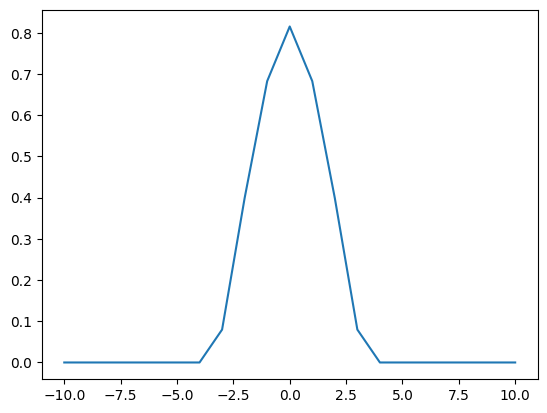

In [176]:
l = [(-10, 0),
(-9, 0),
(-8, 0),
(-7, 0),
(-6, 0),
(-5, 0),
(-4, 0),
(-3, 0.079788456),
(-2, 0.39894228),
(-1, 0.68268949),
(0, 0.81536437),
(1, 0.68268949),
(2, 0.39894228),
(3, 0.079788456),
(4, 0),
(5, 0),
(6, 0),
(7, 0),
(8, 0),
(9, 0),
(10, 0)
]
l = np.array(l)


plt.plot(l[:, 0], l[:, 1])

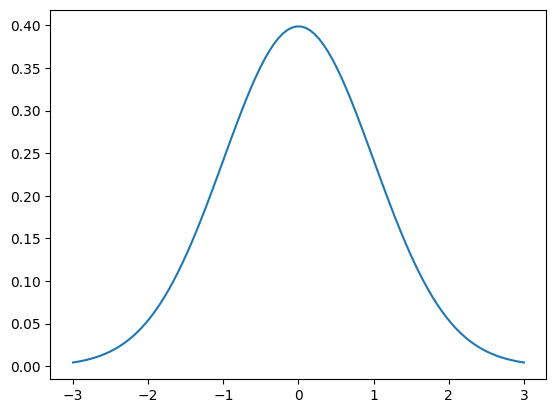

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

Text(0.5, 0, 'Horizontal Axis [cm]')

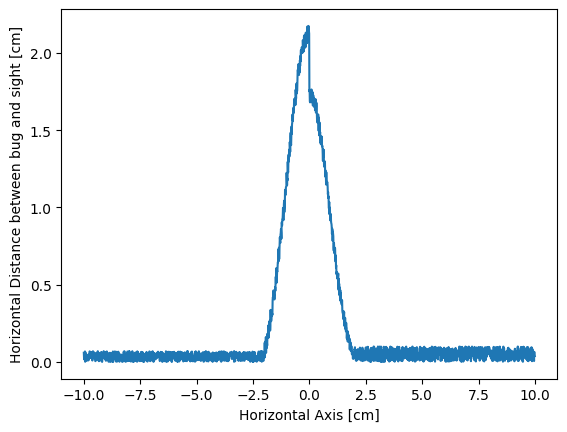

In [215]:
import random

x1 = np.arange(-10, -2, 0.01)
x2 = np.arange(-2, 2, 0.01)
x3 = np.arange(2, 10, 0.01)

y1 = np.zeros((len(x1),)) + 0.07 * np.array([random.random() for _ in range(len(x1))])
y3 = np.zeros((len(x3),)) + 0.1 * np.array([random.random() for _ in range(len(x3))])
y2 = stats.norm.pdf(x2, mu, sigma)
y2 = y2 - y2.min() + 0.02 * np.array([random.random() for _ in range(len(x2))])
y2[len(y2) // 2:] = y2[len(y2) // 2:] ** 1.2
y2 = y2 * 6
plt.plot(np.hstack([x1, x2, x3]), np.hstack([y1, y2, y3]))
plt.ylabel('Horizontal Distance between bug and sight [cm]')
plt.xlabel('Horizontal Axis [cm]')

In [178]:
stats.norm.pdf(x, mu, sigma) + random.random

array([0.00443185, 0.00530579, 0.00632878, 0.00752133, 0.00890582,
       0.0105065 , 0.01234943, 0.01446241, 0.01687483, 0.01961746,
       0.02272223, 0.02622189, 0.03014961, 0.03453857, 0.03942137,
       0.0448295 , 0.05079264, 0.05733801, 0.06448952, 0.07226707,
       0.08068571, 0.08975477, 0.09947714, 0.10984842, 0.12085626,
       0.13247967, 0.14468855, 0.15744319, 0.17069405, 0.18438164,
       0.1984366 , 0.21277993, 0.22732351, 0.24197072, 0.2566174 ,
       0.27115285, 0.28546117, 0.29942268, 0.31291556, 0.3258175 ,
       0.33800759, 0.34936814, 0.35978656, 0.36915722, 0.37738323,
       0.38437808, 0.3900672 , 0.39438923, 0.39729716, 0.39875915,
       0.39875915, 0.39729716, 0.39438923, 0.3900672 , 0.38437808,
       0.37738323, 0.36915722, 0.35978656, 0.34936814, 0.33800759,
       0.3258175 , 0.31291556, 0.29942268, 0.28546117, 0.27115285,
       0.2566174 , 0.24197072, 0.22732351, 0.21277993, 0.1984366 ,
       0.18438164, 0.17069405, 0.15744319, 0.14468855, 0.13247

In [ ]:
n = 20
n = min([n, len(trial_strikes)])
cols = 5
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(25, 4*rows))
axes = axes.flatten()
i = 0
for trial_id, strike_ids in tqdm(trial_strikes.items()):
    try:
        jump_idx = []
        title = ''
        for j, strike_id in enumerate(strike_ids):
            ld = Loader(strike_id, 'front', is_load_pose=False, orm=orm)
            traj = ld.traj_df.copy()
            if j == 0:
                jump_idx = np.where(traj.y.diff().abs() > 40)[0]
                axes[i].plot(traj.x, traj.y)
                direction = '<--' if ld.traj_df.diff().x.mean() < 0 else '-->'
                title = f'# strikes: {len(strike_ids)} - trial ID: {trial_id} - Direction: ({direction})'
                axes[i].scatter(traj.x[jump_idx], traj.y[jump_idx], c='orange', marker='^')
                if len(jump_idx) > 0:
                    title += f'\n# jumps: {len(jump_idx)}'
                else:
                    title += '\nNo jumps in this trial'

            if len(jump_idx) > 0:
                jump_idx_ = jump_idx[jump_idx < ld.bug_traj_strike_id]
                if len(jump_idx_):
                    closest_jump_before = jump_idx_[-1]
                    dt = (ld.traj_df.time[ld.bug_traj_strike_id] - ld.traj_df.time[closest_jump_before]).total_seconds()
                    # title += f'\nStrike #{j+1} - delta_jump={dt * 1000:.0f}ms'
                    # axes[i].scatter(traj.x[closest_jump_before], traj.y[closest_jump_before], c='yellow')
                    axes[i].text(traj.x[ld.bug_traj_strike_id], traj.y[ld.bug_traj_strike_id] - 10, f'{dt * 1000:.0f}')

            axes[i].set_title(title)
            axes[i].invert_yaxis()
            axes[i].scatter(traj.x[ld.bug_traj_strike_id], traj.y[ld.bug_traj_strike_id], c='red')
            axes[i].set_xlim([0, 1700])
            axes[i].set_ylim([800, 250])
    except Exception as exc:
        print(exc)
    else:
        i += 1
    if i >= n:
        break

fig.tight_layout()

In [438]:
af_ = df.query(f'animal_id=="PV91" and movement_type=="jump_up"').copy()
if af_.day_num.min() > 0:
    af_['day_num'] = af_.day_num - af_.day_num.min() 
g_ = af_.groupby('day_num').pred_distance.agg(['mean', 'sem'])
g_

,mean,sem
day_num,,
0.0,2.722227,0.769423
1.0,3.183597,0.727727
2.0,3.148740,0.592846
3.0,4.746818,0.783124
4.0,5.084341,1.253365
5.0,NaN,NaN
6.0,NaN,NaN
7.0,NaN,NaN
8.0,NaN,NaN


<AxesSubplot:xlabel='day_num', ylabel='pred_distance_mean'>

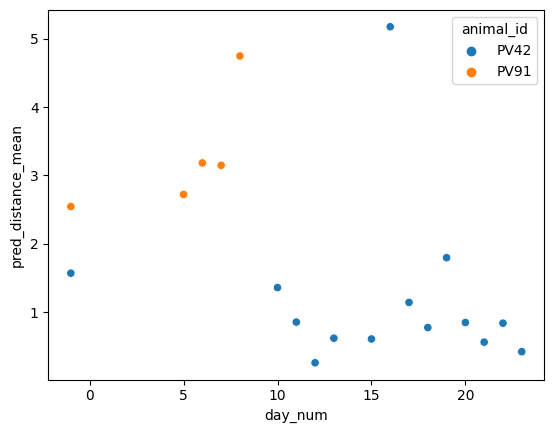

In [99]:
df_ = df.query('movement_type=="random_low_horizontal"').copy()
df_['day_num'] = -1
df_ = pd.concat([df.query('movement_type=="jump_up"'), df_])
df_mean = df_.groupby(['animal_id', 'day_num']).mean()
df_std = df_.groupby(['animal_id', 'day_num']).std()
df_ = df_mean.merge(df_std, left_index=True, right_index=True, suffixes=('_mean', '_std')).reset_index()
sns.scatterplot(data=df_, x='day_num', y='pred_distance_mean', hue='animal_id')

In [91]:
df_std

strike_id  miss_distance  pred_distance
animal_id day_num                                           
PV42      -1.0      236.224545      41.988338       2.523746
           10.0       3.927922      13.684432       1.023319
           11.0     699.721769       9.306878       1.002112
           12.0      45.140790       9.957723       0.105540
           13.0    1122.751086      11.581272       0.533771
           15.0       2.738613      16.191295       0.505352
           16.0       1.290994     321.205624       8.109952
           17.0       2.738613      13.602491       0.962837
           18.0       5.049752     245.304056       0.699125
           19.0       2.738613     115.128537       4.558110
           20.0       3.605551      17.814558       1.358493
           21.0      25.077697      15.491310       0.568092
           22.0       2.160247      21.276438       1.047665
           23.0       5.627314      19.869878       0.313833
PV91      -1.0       38.557725      32.426933       3.130510
           5.0        2.738613      16.103659       2.035703
           6.0       10.535654     170.757307       3.850767
           7.0        7.359801     150.550200       2.843188
           8.0        9.380832     263.074241       3.588724
           9.0        3.605551     126.920815            NaN

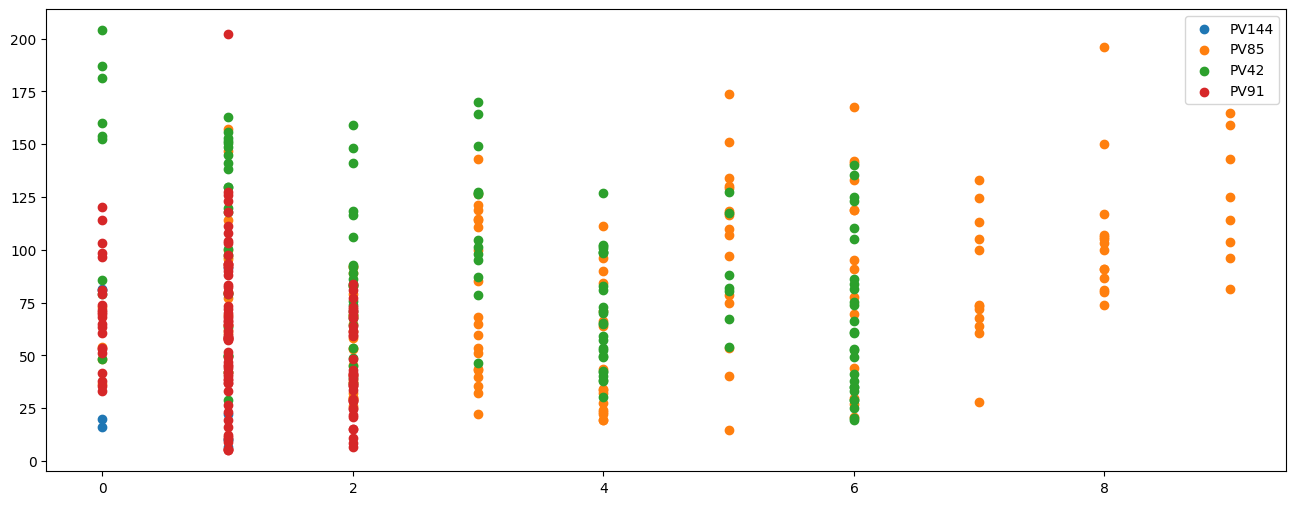

In [73]:

plt.figure(figsize=(16, 6))

    plt.scatter(af_.day_num, af_.miss_distance, label=animal_id)
plt.legend()

In [38]:
sns.scatterplot(data=df, x='time')

time
2023-05-13    70.018101
2023-05-14    62.810435
2023-05-15    43.705058
Name: miss_distance, dtype: float64